This is a compiled notebook for alignment of coronal brain slices via STalign (followed up by VisuAlign manual adjustement) and subsequent region boundary export

Tags:
- "REPLACE ME": places for user to input their own files (required)
- "CHANGE ME": places where user can modify behavior (optional)

In [2]:
#Import dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
import IPython
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
import copy
import skimage as ski
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from STalign import STalign
import nibabel as nib
from scipy.ndimage import rotate
import shapely
from sklearn.cluster import dbscan
import json
%matplotlib tk

Loading in resources, target images, etc

In [15]:
# Loading in target image


img_filename = "Full Test\\stitched.tif" #### REPLACE ME ####
W_original = ski.io.imread(img_filename)
W = W_original.copy()

# uncomment/comment out preprocessing lines as needed, feel free to edit, rearrange, and add your own pre-processing
W = ski.color.rgb2gray(ski.color.rgba2rgb(W)) # greyscaling rgb image
W = (W - np.min(W)) / (np.max(W) - np.min(W)) # normalizing image
W = 1-W # inverting, optional
ds_factor = 1 #### CHANGE ME #### if working with larger image that needs downscaling
W = ski.transform.downscale_local_mean(W, (ds_factor, ds_factor)) # downscaling using above factor

fig, ax = plt.subplots(1,2)
ax[0].imshow(W_original)
ax[0].set_title("Original Target Image")
ax[1].imshow(W,cmap='Grays')
ax[1].set_title("Preprocessed Target Image");
print(f'Target Image has shape {W.shape}')

Target Image has shape (1286, 1248)


In [16]:
# Loading Atlas
# options: DAPI, ALLEN, OTHER 
# RECOMMENDED: DAPI stained Atlas - https://www.nature.com/articles/s41597-020-0570-z
# we use this one because the slices were cryosectioned, stained, and dried on a slide
# which is similar to the protocl used in our lab for the experiment this tool was designed for
# HOWEVER you can also use the allen atlas if that fits your purposes better, OR you can upload
# your own atlas to align to
# if you want to use DAPI atlas, keep <chosen_atlas> = 'DAPI',
# if you want to use Allen atlas, set <chosen_atlas> = 'ALLEN',
# if you want to use another atlas of your choice, set <chosen_atlas> = 'OTHER' AND 
# fill in your own code for uploading the atlas

chosen_atlas = 'DAPI' #### CHANGE ME ####

if chosen_atlas == 'DAPI':

    reference_img = nib.load("dapi_template_with_origin.nii").get_fdata()
    reference_labels = nib.load("dapi_template_segmentation_full_with_origin.nii").get_fdata()

    A_original = np.flip(np.transpose(reference_img,(1,2,0)),axis=(0,1))
    S = np.flip(np.transpose(reference_labels,(1,2,0)),axis=(0,1))


    # downsize for faster stalign then normalize
    atlas_ds_factor = (1,4,4) #### CHANGE ME ####
    A = ski.transform.downscale_local_mean(A_original, atlas_ds_factor)  
    A = np.clip(A, 0, A.max()) # clipping negative values to 0
    A = (A - np.min(A)) / (np.max(A) - np.min(A)) # normalize

    dxS = [33.34,8.6,8.6] # set pixel dims
    dxA = np.multiply(dxS, atlas_ds_factor)
    nxA = A.shape

    dimAtlas = A.shape
    print("DAPI Atlas loaded successfully")

elif chosen_atlas == 'ALLEN':

    A,_ = nrrd.read("ara_nissl_50.nrrd")
    S, hdr = nrrd.read('annotation_50.nrrd')
    S = np.array(S,dtype='float64')

    A = np.array((A - np.min(A)) / (np.max(A) - np.min(A)),dtype='float64') # normalize

    dxA = np.diag(hdr['space directions']) # set pixel dims
    dxS = dxA
    nxA = A.shape # set dimensions of image

    dimAtlas = A.shape
    print("Allen Atlas loaded successfully")

elif chosen_atlas == 'OTHER':
    #### CUSTOM ATLAS UPLOAD ####
    # must load reference atlas data as A
    # must load labels/segmentation as S
    # must set nxA, the dimensions of A
    # must set dxA and dxS, the dimensions of each pixel in the reference and labels atlas
    # the values of dxA and dxS must correspond to the dimensions of the pixels in the directions that match nxA
    # example: if nxA provides dimensions in [anterior-posterior,superior-inferior,left-right], then dxA and dxS must also provide pixel dimensions in the same order
    pass #### CHANGE ME ####


else: print("PLEASE SET <chosen_atlas> to 'DAPI', 'ALLEN', or 'OTHER' ")

xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

DAPI Atlas loaded successfully


Initial Affine Estimation

In [ ]:
# Get Slice and Rotations #
%matplotlib tk
from IPython.display import clear_output

# poitns stored in z,y,x format
deg2rad = lambda deg: np.pi*deg/180
rad2deg = lambda rad: 180*rad/np.pi

rads_5 = deg2rad(5) # radians corresponding to 5 degrees

L_estim = np.array([[1,0,0],
                    [0,1,0],
                    [0,0,1]])

if 'T_estim' not in locals(): # keep translation from previous runs
    T_estim = np.array([0, 0, 0])

if 'thetas' not in locals(): #avoid wiping out thetas from  previous runs
    thetas = [0,0,0] # z, y, x order
show_seg = False

# rotation matrices for along z-axis, y-axis, and x-axis
def z_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [1,       0       ,         0      ],
                        [0, np.cos(rads), -np.sin(rads)],
                        [0, np.sin(rads), np.cos(rads) ]
                    ])

def y_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [ np.cos(rads), 0, np.sin(rads)],
                        [        0      , 1,     0         ],
                        [-np.sin(rads), 0, np.cos(rads)]
                    ])

def x_rot(deg):
    rads = deg2rad(deg)
    return np.array([
                        [np.cos(rads), -np.sin(rads), 0],
                        [np.sin(rads),  np.cos(rads), 0],
                        [       0      ,        0       , 1]
                    ])

alpha = 1.5 # factor to expand meshgrid dimensions by to allow for rotation
xE = [1.5*x for x in xA]
XE = np.stack(np.meshgrid(np.zeros(1),xE[1],xE[2],indexing='ij'),-1)

nS = S.shape
xS = [np.arange(n)*d - (n-1)*d/2  for n,d in zip(nS, dxS)]

## Handle showing atlas ##
slice_from_T = lambda T: int(T_estim[0]/dxA[0] + A.shape[0]/2)
def atlas_img():
    slice_t = (L_estim@XE[...,None])[...,0] + T_estim
    img = STalign.interp3D(xA, A[None].astype('float64'), 
                           slice_t.transpose(3,0,1,2))[0,0,...]
    return img.numpy()

def seg_img():
    slice_t = (L_estim@XE[...,None])[...,0] + T_estim
    img = STalign.interp3D(xS, S[None].astype('float64'), 
                           slice_t.transpose(3,0,1,2), 
                           mode='nearest')[0,0,...]
    return img.numpy()


def show_atlas():
    img = atlas_img()
    '''if show_seg:
        seg = seg_img()
        print('good')
        img = ski.segmentation.mark_boundaries(img,seg.astype('int'), color=(255,0,0), mode='subpixel')
        print('good1')'''
    ax[0].imshow(img, cmap='Grays')
    ax[0].set_title(f'Atlas Slice {slice_from_T(T_estim[0])}/{len(A)}\nx rotation: {thetas[2]}\ny rotation: {thetas[1]}\nz rotation: {thetas[0]}')

def refresh():
    show_atlas()
    plt.draw()

## Event Handling ##

def on_scroll(event):
    if event.inaxes == ax[0]:
        T_estim[0] += event.step*dxA[0]
        msg(f'Slice set to {slice_from_T(T_estim[0])}')

def on_key_press(event):
    if event.key == 'left': rot_y(5)
    elif event.key == 'right': rot_y(-5)
    elif event.key == 'shift+left': rot_y(2.5)
    elif event.key == 'shift+right': rot_y(-2.5)
    elif event.key == 'up': rot_x(5)
    elif event.key == 'down': rot_x(-5)
    elif event.key == 'shift+up': rot_x(2.5)
    elif event.key == 'shift+down': rot_x(-2.5)
    else: msg(f'you pressed {event.key}')

def on_click(event):
    global show_seg
    if event.inaxes == ax[0]:
        if event.button == 1: rot_z(-5)
        elif event.button == 3: rot_z(5)
        '''elif event.button == 2: 
            show_seg = not show_seg
            msg('toggled segmentation')'''

## Handle Rotations ##

def rot_z(rot):
    thetas[0] += rot
    set_L()
    msg(f'rotating along z-axis {rot} degrees, curr angle: {thetas[0]}')

def rot_y(rot):
    thetas[1] += rot
    set_L()
    msg(f'rotating along y-axis {rot} degrees, curr angle: {thetas[1]}')

def rot_x(rot):
    thetas[2] += rot
    set_L()
    msg(f'rotating along x-axis {rot} degrees, curr angle: {thetas[2]}')

## Helper functions ##

# set L
def set_L():
    global L_estim
    L_estim = np.array([[1,0,0],
                        [0,1,0],
                        [0,0,1]])
                        
    L_estim = L_estim@x_rot(thetas[2])
    L_estim = L_estim@y_rot(thetas[1])
    L_estim = L_estim@z_rot(thetas[0])

# output msgs cleanly
def msg(msg):
    clear_output()
    refresh()
    print(msg)

######################### CONTROLS ########################
# scroll up/down: incr/decr slice                         #
# arrow left/right: rot y-axis cw/ccw (top-down view)     #
# arrow up/down: rot x-axis cw/ccw (right side view)      #
# mouse click left/right: rot z-axis ccw/cw (frontal vew) #
###########################################################
fig,ax = plt.subplots(1,2);

set_L()
msg("Starting affine estimator")
ax[1].imshow(W,cmap='Grays');
ax[1].set_title('Target img');
ax[0].set_axis_off()
ax[1].set_axis_off()


fig.canvas.mpl_connect('scroll_event', on_scroll);
fig.canvas.mpl_connect('key_press_event', on_key_press);
fig.canvas.mpl_connect('button_press_event', on_click);

rotating along y-axis 2.5 degrees, curr angle: -2.5


In [44]:
# Get images of estimated slice to use in future steps
# TODO: understand what causes failure every once in a while
slice_img = atlas_img()
print("good!")
slice_labels = seg_img()
print("good!")
bound = ski.segmentation.find_boundaries(slice_labels)
print("good!")
slice_seg = ski.segmentation.mark_boundaries(slice_img, slice_labels.astype('int'),color=(255,0,0),mode='inner')
print("good!")

print(f"ESTIMATED AFFINE (L)\n{L_estim}\nRotation along z,y,x axes respectively:{thetas}\nTranslation along z,y,x axes respectively (um):{T_estim}:")

good!
good!
good!
good!
ESTIMATED AFFINE (L)
[[ 9.95246541e-01  4.34534024e-02  8.71557427e-02]
 [-8.70727898e-02 -3.80168010e-03  9.96194698e-01]
 [ 4.36193874e-02 -9.99048222e-01  6.11740603e-17]]
Rotation along z,y,x axes respectively:[-90, -2.5, -5]
Translation along z,y,x axes respectively (um):[1713    0    0]:


Estimating the voxel dimensions of the target image

In [29]:
# If you know the pixel dimensions of your image, you can add them here, if not, leave it at 0
# The first element should be the length of each pixel in the superior-inferior direction
# The second element should be the length of each pixel in the left-right direction
dxW = [0,0]*ds_factor #### CHANGE ME ####
estimate_dxW = (np.prod(dxW)==0) # if true, need to estimate, else no need to estimate

if estimate_dxW:
    # you'll have to play with this number to achieve a good contour of your target image
    # we use this contour to estimate the scale of your image with respect to the atlas,
    # which allows us to estimate the dimensions
    contour_threshold = 0.4 #### CHANGE ME ####
    cA = ski.measure.find_contours(slice_img, 0.1)[0]
    cT = ski.measure.find_contours(W, contour_threshold)[0]

    area_A = shapely.Polygon(cA).area
    area_T = shapely.Polygon(cT).area
    
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(slice_img, cmap='Grays')
    ax[1].imshow(W, cmap='Grays')

    ax[0].plot(cA[:,1], cA[:,0],c='r')
    ax[1].plot(cT[:,1], cT[:,0],c='r')

    # scale based on ratio of areas
    scale = np.sqrt(area_T / area_A) / alpha # must also correct for expansion of atlas dimensions from alpha
    print(f'Scale: {scale}')
    dxW = (1/scale)*dxA[1:]
    print(f'Estimated dimensions of target image: {dxW}')

xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(W.shape,dxW)]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2)) # comment this line out when using stalign_no_contrast

Scale: 4.2030065151524445
Estimated dimensions of target image: [8.18461734 8.18461734]


Annotating Landmark Points

In [ ]:
### POINT ANNOTATOR ###
# left side is atlas slice
# right side is target image
# use mouse left click to mark a pair of corresponding points on atlas and target
# right click removes the point
# enter commits points to list
# backspace removes most recently committed point
# ctrl+backspace clears all points
# COLOR KEY
# red: new marked point, not committed
# orange: most recently committed point, will be removed with backspace
# black: committed point
# when done selecting and committing points, simply move on to next cell

if 'points' not in locals(): # avoid wiping out points from previous runs of this cell
    points = [[],[]]

show_seg = False
slice_pts = (L_estim@XE[...,None])[...,0] + T_estim

imgs = [slice_img, W]
extents = [STalign.extent_from_x(xE[1:]),STalign.extent_from_x(xJ)]
new_pts = [[],[]]
fig, ax = plt.subplots(1,2, figsize=(15, 15))
pt_sz = 4

def refresh(axis=None):

    # refresh both axes if no axis specified
    if type(axis) == type(None):
        refresh(0)
        refresh(1)
        return
    elif axis not in [0,1]:
        print(f"BAD CALL TO refresh(axis={axis})")
        return
    
    ax[axis].cla()
    ax[axis].imshow(imgs[axis],extent=extents[axis],cmap='Grays')
    if len(points[0]): 
        ax[axis].scatter(np.array(points)[axis,:-1,1],np.array(points)[axis,:-1,0], color='black', s=pt_sz) # plot prev selected points in white
        ax[axis].scatter(np.array(points)[axis,-1,1],np.array(points)[axis,-1,0], color='orange', s=pt_sz) # plot prev selected points in white
    if len(new_pts[axis]):
        ax[axis].scatter(new_pts[axis][1], new_pts[axis][0], color='red', s=pt_sz)

    plt.draw()

def onclick(event):

    if event.button == 2: 
        global show_seg
        show_seg = not show_seg
        if show_seg: imgs[0] = slice_seg
        else: imgs[0] = slice_img
        msg("Toggled segmentation")
        refresh(0)
        return
        
    if event.xdata == None: return # clicked outside of plot
    ix, iy = int(event.xdata), int(event.ydata) # get x and y data of pt
    message = f'[{ix}, {iy}]'
    
    axis = -1
    # based on where user clicked, set axis and update output message
    if event.inaxes == ax[0]:
        axis = 0
        message = "source at " + message
    elif event.inaxes == ax[1]:
        axis = 1
        message = "target at " + message
    else: print("ERROR: clicked outside axes")


    if event.button == 1: # left click means add point at mouse location
        #ax[axis].scatter([ix],[iy], color='red', s=pt_sz)
        new_pts[axis] = [iy, ix]
        message = 'point added to ' + message
    elif event.button == 3: # right click means remove previously created point
        new_pts[axis] = []
        message = 'point removed from ' + message

    msg(message)
    refresh(axis) # refresh that axis to clear out any previously clicked on pts that were not committed



def on_press(event):
    if event.key == 'enter': # enter key used to commit selected points to points list

        if not len(new_pts[0])*len(new_pts[1]): # if missing a point in either axis, throw error
            print("ERROR: attempted landmark save with one or more points missing!")
            return

        # add new points to list, notify user, and clear out new points list
        points[0].append(new_pts[0])
        points[1].append(new_pts[1])
        msg(f"Added [{new_pts[0]}] and [{new_pts[1]}] to points list.\n{len(points[0])} marked points")
        new_pts[0] = []
        new_pts[1] = []
        refresh() # refresh both axes

    elif event.key == 'backspace': # backspace key used to remove recently committed point
        if len(points[0]) == 0: return # if no points to remove, simply return
        msg(f'Removed [{points[0][-1]}] and [{points[1][-1]}]\n{len(points[0])} marked points') # user msg
        
        # remove last pair of poins
        points[0].pop(-1)
        points[1].pop(-1)
        refresh() # refresh both axes
    
    elif event.key == 'ctrl+backspace': #ctr+backspace to remove all poins
        if len(points[0]) == 0: return # if no points to remove, simply return
        msg('Removed all points')
        points[0] = []
        points[1] = []
        new_pts[0] = []
        new_pts[1] = []
        refresh()

# output msgs cleanly
def msg(msg):
    clear_output()
    print(msg)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('key_press_event', on_press)

refresh()
ax[0].set_title('Atlas Slice')
ax[1].set_title('Target Image')

plt.show()

point added to target at [1799, -1500]
ERROR: attempted landmark save with one or more points missing!


In [47]:
### PLOT ANNOTATIONS TO ENSURE ACCURACY ###
points_np = np.array(points)
x_to_pix = lambda x: (x-xE[2][0])/alpha/dxA[2]
y_to_pix = lambda y: (y-xE[1][0])/alpha/dxA[1]

pts_atlas_pix = np.array([[y_to_pix(px[0]), x_to_pix(px[1])] for px in points[0]]).astype(int) # get pixel locations of points on atlas
points_atlas = slice_pts[0, pts_atlas_pix[:,0], pts_atlas_pix[:,1]] # convert that to points pointed to by sampling array (slice_pts)
points_target = np.insert(points_np[1],0,0,axis=1)

Running STalign

In [56]:
#### SETTING PARAMETERS FOR STALIGN ####
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

scale_x = 1
scale_y = 1
scale_z = 1


L = np.linalg.inv(L_estim)
T = -T_estim
scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_y,0],
                        [0,0,scale_x]])
L = np.matmul(L,scale_atlas)

In [57]:
### FUNCTION DEFINITIONS ###

# for LDDMM
def LDDMM_3D_to_slice(xI,I,xJ,J,pointsI=None,pointsJ=None,
        L=None,T=None,A=None,v=None,xv=None,
        a=500.0,p=2.0,expand=1.25,nt=3,
        niter=5000,diffeo_start=0, epL=1e-6, epT=1e1, epV=1e3,
        sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=1e8,sigmaP=2e1,
        device='cpu',dtype=torch.float64, muA=None, muB = None):

        
    # check initial inputs and convert to torch
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:3,:3],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:3,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)
    
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    if J.ndim == 3:
        J = J[:,None] # add a z slice dimension


    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
        
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = STalign.extent_from_x(xv[1:])
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = STalign.extent_from_x(fv[1:])
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki[Ki.shape[0]//2].clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()

    # steps
    epL = torch.tensor(epL,device=device,dtype=dtype)
    epT = torch.tensor(epT,device=device,dtype=dtype)

    # initialize weights
    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1

    # locations of pixels
    extentI = STalign.extent_from_x(xI[1:]) 
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    if len(xJ) == 2:
        xJ = [[0.0],xJ[0],xJ[1]]    
    extentJ = STalign.extent_from_x(xJ[1:])
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ[1:]]

    # a figure
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    if type(pointsI) != type(None): figE,axE = plt.subplots(1,4)
    else: figE,axE = plt.subplots(1,3)
    axE = axE.ravel()
    Esave = []
    # zero gradients
    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass

    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)


    #print(f'pointsJ: {pointsJ}')
    #print(f'pointsI: {pointsI}\n')
    for it in range(niter):
        print(f'Iteration #{it}:')

        torch.autograd.set_detect_anomaly(True)
        # make A
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            #print(Xs.shape)
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        # # and points (not in 3D)        
        #print(np.shape(pointsI))
        
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T
        
       
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        #if pointsIt.shape[0]>0: EP = torch.sum((pointsIt_t - pointsJt)**2)/2.0/sigmaP**2
            
        E = EM + ER #+ EP
        tosave = [E.item(), EM.item(), ER.item()]
        #print(tosave)
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        

        Esave.append( tosave )
        # gradient update
        '''try:
            L.grad.zero_()
        except:
            pass
        try:
            T.grad.zero_()
        except:
            pass
        try:
            v.grad.zero_()
        except:
            pass'''
        E.backward()

        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            #L.grad.zero_()
            #T.grad.zero_()

            # v grad
            vgrad = v.grad
            # smooth it            
            if it >= diffeo_start:
                vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*K[...,None],dim=(1,2,3)).real
                v -= vgrad*epV
            #v.grad.zero_()


        # draw
        if 1==1:#it%10: #TODO:change back to 10
            ax[0].cla()
            Ishow = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
            ax[0].imshow(  Ishow[0,...,0] ,extent=extentJ)
            if pointsIt.shape[0] >0: ax[0].scatter(pointsIt[...,2].clone().detach().cpu(),pointsIt[...,1].clone().detach().cpu(),s=1,color='orange')
            ax[0].set_title('space tformed source')

            ax[1].cla()    
            Ishow = STalign.clip(fAI.permute(1,2,3,0).clone().detach()/torch.max(J).item()).cpu()
            ax[1].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            #ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('contrast tformed source')
            
            ax[5].cla()
            Ishow = STalign.clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,3,0).clone().detach().cpu()*0.5+0.5
            ax[5].imshow(Ishow[0,...,0],extent=extentJ)
            #ax[5].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu(),s=1,color='red')
            #ax[5].scatter(pointsJt[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu(),,s=1,color='yellow')
            ax[5].set_title('Error')

            ax[2].cla()
            Ishow = J.permute(1,2,3,0).cpu()/torch.max(J).item()
            ax[2].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            if pointsIt.shape[0] >0: ax[2].scatter(pointsJ[...,2].clone().detach().cpu(),pointsJ[...,1].clone().detach().cpu(),s=1,color='red')
            ax[2].set_title('Target')

            ax[4].cla()
            ax[4].imshow(STalign.clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu()[0],extent=extentJ)
            #ax[4].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu())
            #ax[4].scatter(pointsJt[:,2].clone().detach().cpu(),pointsJt[:,1].clone().detach().cpu())

            ax[4].set_title('Weights')


            toshow = v[0].clone().detach().cpu() # initial velocity, components are rgb
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
  #toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(STalign.clip(toshow)[toshow.shape[0]//2],extent=extentV)
            ax[3].set_title('velocity')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].legend(['E','EM','ER','EP'])
            axE[0].set_yscale('log')
            axE[1].cla()
            axE[1].plot([e[:2] for e in Esave])
            axE[1].legend(['E','EM'])
            axE[1].set_yscale('log')
            axE[2].cla()
            axE[2].plot([e[2] for e in Esave])
            axE[2].legend(['ER'])
            axE[2].set_yscale('log')
            if pointsIt.shape[0] >0:
                axE[3].cla()
                axE[3].plot([e[3] for e in Esave])
                axE[3].legend(['EP'])
                axE[3].set_yscale('log')
            
            
            fig.canvas.draw()
            figE.canvas.draw()

    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach()
    }

# for LDDMM_LBGFS
def LDDMM_3D_LBGFS(xI,I,xJ,J,pointsI=None,pointsJ=None,
        L=None,T=None,A=None,v=None,xv=None,
        a=500.0,p=2.0,expand=1.25,nt=3,
        niter=5000,diffeo_start=0, epL=1e-6, epT=1e1, epV=1e3,
        sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=1e8,sigmaP=2e1,
        device='cpu',dtype=torch.float64, muA=None, muB = None):

        
    # check initial inputs and convert to torch
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:3,:3],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:3,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)
    
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    if J.ndim == 3:
        J = J[:,None] # add a z slice dimension


    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
        
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = STalign.extent_from_x(xv[1:])
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = STalign.extent_from_x(fv[1:])
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki[Ki.shape[0]//2].clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()

    # initialize weights
    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1

    # locations of pixels
    extentI = STalign.extent_from_x(xI[1:]) 
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    if len(xJ) == 2:
        xJ = [[0.0],xJ[0],xJ[1]]    
    extentJ = STalign.extent_from_x(xJ[1:])
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ[1:]]

    # a figure
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    if type(pointsI) != type(None): figE,axE = plt.subplots(1,4)
    else: figE,axE = plt.subplots(1,3)
    axE = axE.ravel()
    Esave = []
    # zero gradients
    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass

    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype)
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)

    optimizer = torch.optim.Adam([L, T,v], lr=1e-3)#, max_iter=4, line_search_fn="strong_wolfe")
    def closure():
        optimizer.zero_grad()
        
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T 
       
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
            
        E = EM + ER
        
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP

        E.backward(retain_graph=True)
        return E
    
    for it in range(niter):
        print(f'Iteration #{it}:')

        torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()        
        # make A
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            #print(Xs.shape)
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        # # and points (not in 3D)        
        #print(np.shape(pointsI))
        
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T
        
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        #if pointsIt.shape[0]>0: EP = torch.sum((pointsIt_t - pointsJt)**2)/2.0/sigmaP**2
            
        E = EM + ER #+ EP
        tosave = [E.item(), EM.item(), ER.item()]
        
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
    
        E.backward()
        optimizer.step()
        Esave.append( tosave )
        # gradient update
        '''try:
            L.grad.zero_()
        except:
            pass
        try:
            T.grad.zero_()
        except:
            pass
        try:
            v.grad.zero_()
        except:
            pass'''
        '''E.backward()

        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            #L.grad.zero_()
            #T.grad.zero_()

            # v grad
            vgrad = v.grad
            # smooth it            
            if it >= diffeo_start:
                vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*K[...,None],dim=(1,2,3)).real
                v -= vgrad*epV'''
            #v.grad.zero_()

    # draw
#if it%10:
    ax[0].cla()
    Ishow = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
    ax[0].imshow(  Ishow[0,...,0] ,extent=extentJ)
    if pointsIt.shape[0] >0: ax[0].scatter(pointsIt[...,2].clone().detach().cpu(),pointsIt[...,1].clone().detach().cpu(),s=1,color='orange')
    ax[0].set_title('space tformed source')

    ax[1].cla()    
    Ishow = STalign.clip(fAI.permute(1,2,3,0).clone().detach()/torch.max(J).item()).cpu()
    ax[1].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
    #ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
    ax[1].set_title('contrast tformed source')
    
    ax[5].cla()
    Ishow = STalign.clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,3,0).clone().detach().cpu()*0.5+0.5
    ax[5].imshow(Ishow[0,...,0],extent=extentJ)
    #ax[5].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu(),s=1,color='red')
    #ax[5].scatter(pointsJt[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu(),,s=1,color='yellow')
    ax[5].set_title('Error')

    ax[2].cla()
    Ishow = J.permute(1,2,3,0).cpu()/torch.max(J).item()
    ax[2].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
    if pointsIt.shape[0] >0: ax[2].scatter(pointsJ[...,2].clone().detach().cpu(),pointsJ[...,1].clone().detach().cpu(),s=1,color='red')
    ax[2].set_title('Target')

    ax[4].cla()
    ax[4].imshow(STalign.clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu()[0],extent=extentJ)
    #ax[4].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu())
    #ax[4].scatter(pointsJt[:,2].clone().detach().cpu(),pointsJt[:,1].clone().detach().cpu())

    ax[4].set_title('Weights')


    toshow = v[0].clone().detach().cpu() # initial velocity, components are rgb
    toshow /= torch.max(torch.abs(toshow))
    toshow = toshow*0.5+0.5
#toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
    ax[3].cla()
    ax[3].imshow(STalign.clip(toshow)[toshow.shape[0]//2],extent=extentV)
    ax[3].set_title('velocity')
    
    axE[0].cla()
    axE[0].plot(Esave)
    axE[0].legend(['E','EM','ER','EP'])
    axE[0].set_yscale('log')
    axE[1].cla()
    axE[1].plot([e[:2] for e in Esave])
    axE[1].legend(['E','EM'])
    axE[1].set_yscale('log')
    axE[2].cla()
    axE[2].plot([e[2] for e in Esave])
    axE[2].legend(['ER'])
    axE[2].set_yscale('log')
    if pointsIt.shape[0] >0:
        axE[3].cla()
        axE[3].plot([e[3] for e in Esave])
        axE[3].legend(['EP'])
        axE[3].set_yscale('log')
    
    
    fig.canvas.draw()
    figE.canvas.draw()

    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach()
    }

c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration #0:
Iteration #1:
Iteration #2:
Iteration #3:
Iteration #4:
Iteration #5:
Iteration #6:
Iteration #7:
Iteration #8:
Iteration #9:


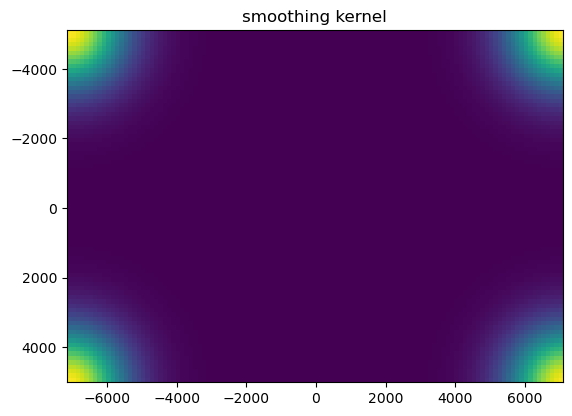

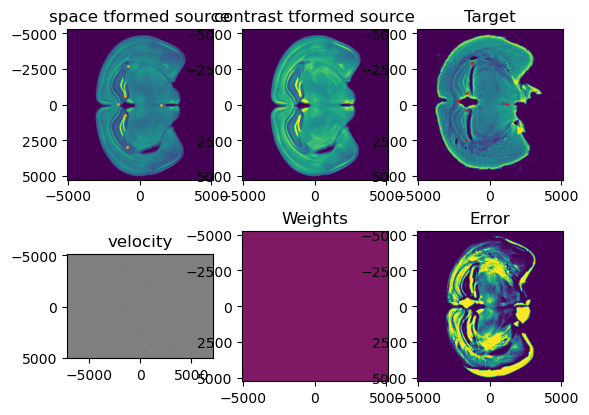

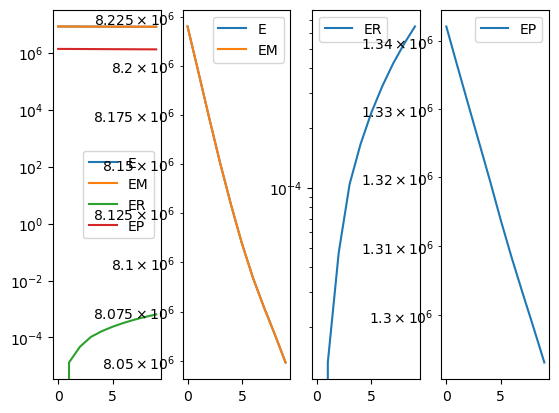

CPU times: total: 23.1 s
Wall time: 27.6 s


In [58]:
%%time
%matplotlib tk
# Running the model
# Two versions of the model: NORMAL and LBGFS
# NORMAL requires more hyperparameters which allows for more customization, but takes more testing and experimentation
# LBGFS takes care of the hyperparameters, making it easier to use at the slight expense of accuracy

model_type = "LBGFS" ### CHANGE ME ###

if model_type == 'NORMAL':
    transform = LDDMM_3D_to_slice(
        xI,I,xJ,J,
        T=T,L=L,
        nt=12,niter=5,
        device=device,
        sigmaM = .2, #standard deviation of matching tissue intenities
        sigmaP = 1,
        sigmaR = 3e6,
        pointsI=points_atlas,
        pointsJ=points_target,
        
        a = 250,
        epL = 1e-9,
        epT = 1e-9,
        epV = 5e2,
    )
elif model_type == 'LBGFS':
    transform = LDDMM_3D_LBGFS(
        xI,I,xJ,J,
        T=T,L=L,
        nt=12,niter=10,
        device=device,
        sigmaM = .5, #standard deviation of matching tissue intenities
        sigmaP = 1,
        sigmaR = 1e8,
        pointsI=points_atlas,
        pointsJ=points_target,
        a = 250,

    )
else:
    print("ERROR: please set <model_type> to NORMAL or LBGFS")
%matplotlib inline
plt.show()

Generate Segmentation

In [70]:
%matplotlib tk
At = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

vol = S
dxL = dxS
nL = vol.shape
xL = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nL,dxL)]

# next chose points to sample on
res = 10.0
XJ = np.stack(np.meshgrid(np.zeros(1),xJ[0],xJ[1],indexing='ij'),-1)

tform = STalign.build_transform3D(xv,v,At,direction='b',XJ=torch.tensor(XJ,device=At.device))

AphiL = STalign.interp3D(
        xL,
        torch.tensor(vol[None].astype(np.float64),dtype=torch.float64,device=tform.device),
        tform.permute(-1,0,1,2),
        mode='nearest',)[0,0].cpu().int()

region_graph = AphiL.numpy()

brain_regions_id = np.unique(region_graph)

fig, ax = plt.subplots(1,2,figsize=(15,15))
seg = ski.segmentation.mark_boundaries(1-W,region_graph, mode='thick', background_label=0, color=(1,0,0))
print(seg.shape)
ax[0].imshow(seg, extent=extents[1], cmap='Grays')
ax[1].imshow(slice_img,extent=extents[0])

ax[0].scatter(points_np[1,:,1],points_np[1,:,0],color='red', s=1.5)
ax[1].scatter(points_np[0,:,1],points_np[0,:,0],color='red', s=1.5)

plt.show()

c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1725: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1726: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1738: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


(1286, 1248, 3)


Manual Adjustment via VisuAlign

In [71]:
# TODO: customiz to fit to images shape
# Packaging transformed atlas in a NIFTI
seg_hdr = nib.load("dapi_template_segmentation_full_with_origin.nii").header
seg_hdr_arr = seg_hdr.structarr
seg_hdr_arr['regular'] = b''
seg_hdr_arr['dim'] = np.array([3, region_graph.shape[1], 1, region_graph.shape[0], 0, 0, 0, 0]) #TODO: needs to match image shape
seg_hdr_arr['pixdim'] = np.array([1., 1, 1, 1, 0, 0, 0, 0])
seg_hdr_arr['datatype'] = 8 # changed to represent int32, #TODO: if not working try for uint32
seg_hdr_arr['bitpix'] = 32
seg_hdr_arr['qoffset_x'] = 0
seg_hdr_arr['qoffset_y'] = 0
seg_hdr_arr['qoffset_z'] = 0
seg_hdr_arr['srow_x'] = np.array([1,0,0,0])
seg_hdr_arr['srow_y'] = np.array([0,1,0,0])
seg_hdr_arr['srow_z'] = np.array([0,0,1,0])
seg_nifti_data = np.transpose(np.flip(region_graph[None], axis=(0,1)), (-1,0,1))
#seg_affine = nib.load("dapi_template_segmentation_full_with_origin.nii").affine
#seg_affine[0,0] = 0.03333334
#seg_affine[2,2] = 0.03333334
seg_affine = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0],
                       [0,0,0,1]])

seg_nifti = nib.Nifti1Image(seg_nifti_data, seg_affine, seg_hdr)
nib.save(seg_nifti, "labels_atg.nii") # TODO: come up with a full process for this that cleans up after itself

Getting Region Boundaries from Segmentation

In [5]:
# Loading in final segmentation from visualign
visualign_nl_flat_filename = 'Full Test\\testwhyopil\\stitched_nl.flat' #### REPLACE ME ####

with open(visualign_nl_flat_filename, 'rb') as fp:
    buffer = fp.read()
nDims = int(buffer[0])
shape = np.frombuffer(buffer, dtype=np.dtype('>i4'), offset=1, count=2) 
data = np.frombuffer(buffer, dtype=np.dtype('>i2'), offset=9)
data = data.reshape(shape[::-1])
data = data[:-1,:-1]

# Loading in color table
with open('Rainbow 2017.json') as fp:
    table = json.load(fp)
region_names_nutil = [row['name'] for row in table]

present_regions = np.unique(data)
print("Present Regions:")
for r in present_regions: 
    try: 
        print(f'{r}:{region_names_nutil[r]}')
    except:
        print(r)

Present Regions:
0:empty
1:root
53:Primary somatosensory area, barrel field, layer 1
54:Primary somatosensory area, barrel field, layer 2/3
55:Primary somatosensory area, barrel field, layer 4
56:Primary somatosensory area, barrel field, layer 5
57:Primary somatosensory area, barrel field, layer 6a
58:Primary somatosensory area, barrel field, layer 6b
88:Primary somatosensory area, trunk, layer 1
89:Primary somatosensory area, trunk, layer 2/3
90:Primary somatosensory area, trunk, layer 4
91:Primary somatosensory area, trunk, layer 5
92:Primary somatosensory area, trunk, layer 6a
93:Primary somatosensory area, trunk, layer 6b
102:Supplemental somatosensory area, layer 1
103:Supplemental somatosensory area, layer 2/3
104:Supplemental somatosensory area, layer 4
105:Supplemental somatosensory area, layer 5
106:Supplemental somatosensory area, layer 6a
107:Supplemental somatosensory area, layer 6b
124:Dorsal auditory area, layer 1
125:Dorsal auditory area, layer 2/3
126:Dorsal auditory ar

In [6]:
fig,ax = plt.subplots()
data_seg = ski.segmentation.mark_boundaries(ski.color.rgba2rgb(W_original),data, mode='thick', background_label=0, color=(0,0,0))
ax.imshow(data_seg)
ax.set_axis_off()

In [9]:
# Loading in list of regions to extract
# TODO: create interactive picker or have option to upload file with names
extraction_filename = '' #### REPLACE ME ####
roi_names = ['Primary somatosensory area, trunk, layer 2/3'] # TODO: actually implement reading of extraction_file



In [10]:
# Generate boundaries
rois = [region_names_nutil.index(roin) for roin in roi_names]
fig,ax = plt.subplots()
ax.imshow(W_original)


region_bounds = {}
for i,roi in enumerate(rois):
    pts = np.argwhere(data==roi)

    cores,labels = dbscan(pts, eps=2, min_samples=5, metric='manhattan')

    for l in set(labels):
        if l == -1: continue # these points dont belong to any clusters
        cluster = pts[labels==l]
        shape_name = f'{region_names_nutil[roi]}_{l}'

        hull = shapely.concave_hull(shapely.MultiPoint(cluster), 0.1) # get hull for cluster
        
        # only hulls defined as polygons can actually be cut out, other hulls will not be shown
        if hull.geom_type == 'Polygon':
            bound = shapely.get_coordinates(hull)
            ax.plot(bound[:,1],bound[:,0], lw=.75, label=region_names_nutil[roi])
            region_bounds[shape_name] = bound
            



Exporting Boundaries

In [119]:
# TODO: design calibration pt selection
calibration_pts = [[186.1,223.3],[883.5,223.3],[883.5,1187.8]]

In [117]:
for i,s in enumerate(region_bounds.values()): print(i,s.shape)

0 (77, 2)
1 (74, 2)
2 (82, 2)
3 (79, 2)
4 (111, 2)
5 (109, 2)


In [120]:
# Export to xml
# Provide an output filename (make sure to keep the .xml extension)
output_filename = 'full_test.xml' #### REPLACE ME ####

with open(output_filename,'w') as file:
    file.write("<ImageData>\n")
    file.write("<GlobalCoordinates>1</GlobalCoordinates>\n")
    for i,pt in enumerate(calibration_pts):
        file.write(f"<X_CalibrationPoint_{i+1}>{pt[0]}</X_CalibrationPoint_{i+1}>\n")
        file.write(f"<Y_CalibrationPoint_{i+1}>{pt[1]}</Y_CalibrationPoint_{i+1}>\n")
    file.write(f"<ShapeCount>{len(region_bounds)}</ShapeCount>\n")

    for i,shape in enumerate(region_bounds.values()):
        file.write(f'<Shape_{i+1}>\n')
        file.write(f'<PointCount>{len(shape)+1}</PointCount>\n')

        for j in range(len(shape)+1):
            file.write(f'<X_{j+1}>{shape[j%len(shape)][1]}</X_{j+1}>\n')
            file.write(f'<Y_{j+1}>{shape[j%len(shape)][0]}</Y_{j+1}>\n')

        file.write(f'</Shape_{i+1}>\n')

    file.write("</ImageData>")

In [61]:
import subprocess
import sys

visualign_fileloc = "C:\\Users\\kebsc\\Documents\\Rishi\\VisuAlign-v0_9\\VisuAlign.bat"
subprocess.call('@C:\\Users\\kebsc\\Documents\\Rishi\\VisuAlign-v0_9\\bin\\java --module qnonlin/visualign.QNonLin')
#subprocess.check_call(visualign_fileloc)


FileNotFoundError: [WinError 2] The system cannot find the file specified